In [ ]:
# Linking Google drive to use preprocessed data
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')
#/content/drive/My Drive//

Mounted at /content/drive


# II. General imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import scipy.io
from sklearn.metrics import average_precision_score, precision_recall_curve

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from torchvision import transforms
import torchvision.models as models
from torch.optim.lr_scheduler import StepLR

print ('completed cell')

completed cell


# III. Emotic classes

## Emotic Model

In [ ]:
class Emotic(nn.Module):
  ''' Emotic Model'''
  def __init__(self, num_context_features, num_body_features, num_face_features):
    super(Emotic,self).__init__()
    self.num_context_features = num_context_features
    self.num_body_features = num_body_features
    self.num_face_features = num_face_features
    self.fc1 = nn.Linear((self.num_context_features + self.num_body_features + self.num_face_features), 256)
    self.bn1 = nn.BatchNorm1d(256)
    self.d1 = nn.Dropout(p=0.5)
    self.fc_cont = nn.Linear(256, 3)
    self.relu = nn.ReLU()


  def forward(self, x_context, x_body, x_face):
    context_features = x_context.view(-1, self.num_context_features)
    body_features = x_body.view(-1, self.num_body_features)
    face_features = x_face.view(-1, self.num_face_features)
    fuse_features = torch.cat((context_features, body_features, face_features), 1)
    fuse_out = self.fc1(fuse_features)
    fuse_out = self.bn1(fuse_out)
    fuse_out = self.relu(fuse_out)
    fuse_out = self.d1(fuse_out)
    cont_out = self.fc_cont(fuse_out)
    return cont_out

print ('completed cell')

completed cell


## Emotic Dataset

In [ ]:
class Emotic_PreDataset(Dataset):
  ''' Custom Emotic dataset class. Use preprocessed data stored in npy files. '''
  def __init__(self, x_context, x_body, x_face, y_cat, y_cont, transform, context_norm, body_norm, face_norm):
    super(Emotic_PreDataset,self).__init__()
    self.x_context = x_context
    self.x_body = x_body
    self.x_face = x_face
    self.y_cat = y_cat
    self.y_cont = y_cont
    self.transform = transform
    self.context_norm = transforms.Normalize(context_norm[0], context_norm[1])  # Normalizing the context image with context mean and context std
    self.body_norm = transforms.Normalize(body_norm[0], body_norm[1])           # Normalizing the body image with body mean and body std
    self.face_norm = transforms.Normalize(face_norm[0], face_norm[1])

  def __len__(self):
    return len(self.y_cat)

  def __getitem__(self, index):
    image_context = self.x_context[index]
    image_body = self.x_body[index]
    image_face = self.x_face[index]
    cat_label = self.y_cat[index]
    cont_label = self.y_cont[index]
    return self.context_norm(self.transform(image_context)), self.body_norm(self.transform(image_body)), self.face_norm(self.transform(image_face)), torch.tensor(cat_label, dtype=torch.float32), torch.tensor(cont_label, dtype=torch.float32)/10.0

print ('completed cell')

completed cell


## Emotic Losses

In [ ]:
class DiscreteLoss(nn.Module):
  ''' Class to measure loss between categorical emotion predictions and labels.'''
  def __init__(self, weight_type='mean', device=torch.device('cpu')):
    super(DiscreteLoss, self).__init__()
    self.weight_type = weight_type
    self.device = device
    if self.weight_type == 'mean':
      self.weights = torch.ones((1,26))/26.0
      self.weights = self.weights.to(self.device)
    elif self.weight_type == 'static':
      self.weights = torch.FloatTensor([0.1435, 0.1870, 0.1692, 0.1165, 0.1949, 0.1204, 0.1728, 0.1372, 0.1620,
         0.1540, 0.1987, 0.1057, 0.1482, 0.1192, 0.1590, 0.1929, 0.1158, 0.1907,
         0.1345, 0.1307, 0.1665, 0.1698, 0.1797, 0.1657, 0.1520, 0.1537]).unsqueeze(0)
      self.weights = self.weights.to(self.device)

  def forward(self, pred, target):
    if self.weight_type == 'dynamic':
      self.weights = self.prepare_dynamic_weights(target)
      self.weights = self.weights.to(self.device)
    loss = (((pred - target)**2) * self.weights)
    return loss.sum()

  def prepare_dynamic_weights(self, target):
    target_stats = torch.sum(target, dim=0).float().unsqueeze(dim=0).cpu()
    weights = torch.zeros((1,26))
    weights[target_stats != 0 ] = 1.0/torch.log(target_stats[target_stats != 0].data + 1.2)
    weights[target_stats == 0] = 0.0001
    return weights


class ContinuousLoss_L2(nn.Module):
  ''' Class to measure loss between continuous emotion dimension predictions and labels. Using l2 loss as base. '''
  def __init__(self, margin=1):
    super(ContinuousLoss_L2, self).__init__()
    self.margin = margin

  def forward(self, pred, target):
    labs = torch.abs(pred - target)
    loss = labs ** 2
    loss[ (labs < self.margin) ] = 0.0
    return loss.sum()


class ContinuousLoss_SL1(nn.Module):
  ''' Class to measure loss between continuous emotion dimension predictions and labels. Using smooth l1 loss as base. '''
  def __init__(self, margin=1):
    super(ContinuousLoss_SL1, self).__init__()
    self.margin = margin

  def forward(self, pred, target):
    labs = torch.abs(pred - target)
    loss = 0.5 * (labs ** 2)
    loss[ (labs > self.margin) ] = labs[ (labs > self.margin) ] - 0.5
    return loss.sum()

print ('completed cell')

completed cell


# IV. Load preprocessed data

In [ ]:
# # Change data_src variable as per your drive
data_src = '/content/drive/MyDrive/VA-prediction/dataset'

saliency_method = ''


#salieny train
train_context = np.load(os.path.join(data_src,'pre', saliency_method + 'train_context_arr.npy'))
train_body = np.load(os.path.join(data_src,'pre',saliency_method + 'train_body_arr.npy'))

train_cat = np.load(os.path.join(data_src,'pre','train_cat_arr.npy'))
train_cont = np.load(os.path.join(data_src,'pre','train_cont_arr.npy'))


#salieny val
val_context = np.load(os.path.join(data_src,'pre',saliency_method + 'val_context_arr.npy'))
val_body = np.load(os.path.join(data_src,'pre',saliency_method + 'val_body_arr.npy'))

val_cat = np.load(os.path.join(data_src,'pre','val_cat_arr.npy'))
val_cont = np.load(os.path.join(data_src,'pre','val_cont_arr.npy'))


#salieny test
test_context = np.load(os.path.join(data_src,'pre',saliency_method + 'test_context_arr.npy'))
test_body = np.load(os.path.join(data_src,'pre',saliency_method + 'test_body_arr.npy'))\

test_cat = np.load(os.path.join(data_src,'pre','test_cat_arr.npy'))
test_cont = np.load(os.path.join(data_src,'pre','test_cont_arr.npy'))

#Face data
train_face =  np.stack((np.load(os.path.join(data_src,'pre','train_face_arr.npy')),) * 3, axis=-1)
val_face = np.stack((np.load(os.path.join(data_src,'pre','val_face_arr.npy')),) * 3, axis=-1)
test_face = np.stack((np.load(os.path.join(data_src,'pre','test_face_arr.npy')),) * 3, axis=-1)

# Categorical emotion classes
cat = ['Affection', 'Anger', 'Annoyance', 'Anticipation', 'Aversion', 'Confidence', 'Disapproval', 'Disconnection',
       'Disquietment', 'Doubt/Confusion', 'Embarrassment', 'Engagement', 'Esteem', 'Excitement', 'Fatigue', 'Fear',
       'Happiness', 'Pain', 'Peace', 'Pleasure', 'Sadness', 'Sensitivity', 'Suffering', 'Surprise', 'Sympathy', 'Yearning']

cat2ind = {}
ind2cat = {}
for idx, emotion in enumerate(cat):
  cat2ind[emotion] = idx
  ind2cat[idx] = emotion

print ('train ', 'context ', train_context.shape, 'body', train_body.shape, 'cat ', train_cat.shape, 'cont', train_cont.shape)
print ('val ', 'context ', val_context.shape, 'body', val_body.shape, 'cat ', val_cat.shape, 'cont', val_cont.shape)
print ('test ', 'context ', test_context.shape, 'body', test_body.shape, 'cat ', test_cat.shape, 'cont', test_cont.shape)
print ('completed cell')

train  context  (23266, 224, 224, 3) body (23266, 128, 128, 3) cat  (23266, 26) cont (23266, 3)
val  context  (3315, 224, 224, 3) body (3315, 128, 128, 3) cat  (3315, 26) cont (3315, 3)
test  context  (7203, 224, 224, 3) body (7203, 128, 128, 3) cat  (7203, 26) cont (7203, 3)
completed cell


In [ ]:
batch_size = 26

context_mean = [0.4690646, 0.4407227, 0.40508908]
context_std = [0.2514227, 0.24312855, 0.24266963]

body_mean = [0.43832874, 0.3964344, 0.3706214]
body_std = [0.24784276, 0.23621225, 0.2323653]

face_mean = [0.507395516207, 0.507395516207, 0.507395516207]
face_std = [0.255128989415, 0.255128989415, 0.255128989415]

context_norm = [context_mean, context_std]
body_norm = [body_mean, body_std]
face_norm = [face_mean, face_std]

train_transform = transforms.Compose([transforms.ToPILImage(),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
                                      transforms.ToTensor()])

test_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.ToTensor()])

train_dataset = Emotic_PreDataset(train_context, train_body, train_face, train_cat, train_cont, \
                                  train_transform, context_norm, body_norm, face_norm)
val_dataset = Emotic_PreDataset(val_context, val_body, val_face, val_cat, val_cont, \
                                test_transform, context_norm, body_norm, face_norm)
test_dataset = Emotic_PreDataset(test_context, test_body, test_face, test_cat, test_cont, \
                                 test_transform, context_norm, body_norm, face_norm)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

print ('train loader ', len(train_loader), 'val loader ', len(val_loader), 'test', len(test_loader))
print ('completed cell')

train loader  894 val loader  128 test 278
completed cell


# V. PREPARE MODEL

## Resnet-18 (ImageNet) + Resnet-18 (Places365)

In [ ]:
# Get Resnet18 model trained on places dataset.
!mkdir ./places
!wget http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar -O ./places/resnet18_places365.pth.tar

--2023-07-20 14:01:28--  http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar
Resolving places2.csail.mit.edu (places2.csail.mit.edu)... 128.52.132.120
Connecting to places2.csail.mit.edu (places2.csail.mit.edu)|128.52.132.120|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45506139 (43M) [application/x-tar]
Saving to: ‘./places/resnet18_places365.pth.tar’

./places/resnet18_p 100%[===================>]  43.40M  9.74MB/s    in 4.9s    

2023-07-20 14:01:34 (8.87 MB/s) - ‘./places/resnet18_places365.pth.tar’ saved [45506139/45506139]



In [ ]:
# the architecture to use
arch = 'resnet18'
model_weight = os.path.join('./places', 'resnet18_places365.pth.tar')

# create the network architecture
model = models.__dict__[arch](num_classes=365)

#model_weight = '%s_places365.pth.tar' % arch

checkpoint = torch.load(model_weight, map_location=lambda storage, loc: storage) # model trained in GPU could be deployed in CPU machine like this!
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()} # the data parallel layer will add 'module' before each layer name
model.load_state_dict(state_dict)
model.eval()

model.cpu()
torch.save(model.state_dict(), './places/resnet18_state_dict.pth')
print ('completed cell')

completed cell


In [ ]:
model_path_places = './places'

model_context = models.__dict__[arch](num_classes=365)
context_state_dict = torch.load(os.path.join(model_path_places, 'resnet18_state_dict.pth'))
model_context.load_state_dict(context_state_dict)

model_body = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

print (summary(model_context, (3,224,224), device="cpu"))
print (summary(model_body, (3,224,224), device="cpu"))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 115MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

## Resnet-50 (ImageNet) + Resnet-50 (Places365)

In [ ]:
# Get Resnet50 model trained on places dataset.
!mkdir ./places
!wget http://places2.csail.mit.edu/models_places365/resnet50_places365.pth.tar -O ./places/resnet50_places365.pth.tar

--2023-07-20 23:59:21--  http://places2.csail.mit.edu/models_places365/resnet50_places365.pth.tar
Resolving places2.csail.mit.edu (places2.csail.mit.edu)... 128.52.132.120
Connecting to places2.csail.mit.edu (places2.csail.mit.edu)|128.52.132.120|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 97270159 (93M) [application/x-tar]
Saving to: ‘./places/resnet50_places365.pth.tar’

./places/resnet50_p 100%[===================>]  92.76M  13.7MB/s    in 8.4s    

2023-07-20 23:59:31 (11.0 MB/s) - ‘./places/resnet50_places365.pth.tar’ saved [97270159/97270159]



In [ ]:
# the architecture to use
arch50 = 'resnet50'
model_weight = os.path.join('./places', 'resnet50_places365.pth.tar')

# create the network architecture
model = models.__dict__[arch50](num_classes=365)

#model_weight = '%s_places365.pth.tar' % arch

checkpoint = torch.load(model_weight, map_location=lambda storage, loc: storage) # model trained in GPU could be deployed in CPU machine like this!
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()} # the data parallel layer will add 'module' before each layer name
model.load_state_dict(state_dict)
model.eval()

model.cpu()
torch.save(model.state_dict(), './places/resnet50_state_dict.pth')
print ('completed cell')

completed cell


In [ ]:
model_path_places = './places'

model_context = models.__dict__[arch50](num_classes=365)
context_state_dict = torch.load(os.path.join(model_path_places, 'resnet50_state_dict.pth'))
model_context.load_state_dict(context_state_dict)

model_body = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

print (summary(model_context, (3,224,224), device="cpu"))
print (summary(model_body, (3,224,224), device="cpu"))


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 188MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

## Resnet50(Emotic) + Resnet50 (Places365)

In [ ]:
# Get Resnet50 model trained on places dataset.
!mkdir ./places
!wget http://places2.csail.mit.edu/models_places365/resnet50_places365.pth.tar -O ./places/resnet50_places365.pth.tar

In [ ]:
# the architecture to use
arch50 = 'resnet50'
model_weight = os.path.join('./places', 'resnet50_places365.pth.tar')

# create the network architecture
model = models.__dict__[arch50](num_classes=365)

#model_weight = '%s_places365.pth.tar' % arch

checkpoint = torch.load(model_weight, map_location=lambda storage, loc: storage) # model trained in GPU could be deployed in CPU machine like this!
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()} # the data parallel layer will add 'module' before each layer name
model.load_state_dict(state_dict)
model.eval()

model.cpu()
torch.save(model.state_dict(), './places/resnet50_state_dict.pth')
print ('completed cell')

completed cell


In [ ]:
model_path_places = './places'

model_context = models.__dict__[arch50](num_classes=365)
context_state_dict = torch.load(os.path.join(model_path_places, 'resnet50_state_dict.pth'))
model_context.load_state_dict(context_state_dict)

model_body = torch.load('/content/drive/MyDrive/VA-prediction/models/body_train_lr001_b24_crossEtropy/model1.pth')


print (summary(model_context, (3,224,224), device="cpu"))
print (summary(model_body, (3,128,128), device="cpu"))

## SwinT (ImageNet) + Resnet50 (Places365)

In [ ]:
model_body = models.swin_t(weights = 'DEFAULT')

Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /root/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth
100%|██████████| 108M/108M [00:00<00:00, 180MB/s]


In [ ]:
# Get Resnet50 model trained on places dataset.
!mkdir ./places
!wget http://places2.csail.mit.edu/models_places365/resnet50_places365.pth.tar -O ./places/resnet50_places365.pth.tar

--2023-07-23 06:18:38--  http://places2.csail.mit.edu/models_places365/resnet50_places365.pth.tar
Resolving places2.csail.mit.edu (places2.csail.mit.edu)... 128.52.132.120
Connecting to places2.csail.mit.edu (places2.csail.mit.edu)|128.52.132.120|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 97270159 (93M) [application/x-tar]
Saving to: ‘./places/resnet50_places365.pth.tar’

./places/resnet50_p 100%[===================>]  92.76M  41.7MB/s    in 2.2s    

2023-07-23 06:18:41 (41.7 MB/s) - ‘./places/resnet50_places365.pth.tar’ saved [97270159/97270159]



In [ ]:
# the architecture to use
arch50 = 'resnet50'
model_weight = os.path.join('./places', 'resnet50_places365.pth.tar')

# create the network architecture
model = models.__dict__[arch50](num_classes=365)

#model_weight = '%s_places365.pth.tar' % arch

checkpoint = torch.load(model_weight, map_location=lambda storage, loc: storage) # model trained in GPU could be deployed in CPU machine like this!
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()} # the data parallel layer will add 'module' before each layer name
model.load_state_dict(state_dict)
model.eval()

model.cpu()
torch.save(model.state_dict(), './places/resnet50_state_dict.pth')
print ('completed cell')

completed cell


In [ ]:
model_path_places = './places'

model_context = models.__dict__[arch50](num_classes=365)
context_state_dict = torch.load(os.path.join(model_path_places, 'resnet50_state_dict.pth'))
model_context.load_state_dict(context_state_dict)

print (summary(model_context, (3,224,224), device="cpu"))
print (summary(model_body, (3,128,128), device="cpu"))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
class Emotic_PreDataset(Dataset):
  ''' Custom Emotic dataset class. Use preprocessed data stored in npy files. '''
  def __init__(self, x_context, x_body, x_face, y_cat, y_cont, transform, face_transform, context_norm, body_norm, face_norm):
    super(Emotic_PreDataset,self).__init__()
    self.x_context = x_context
    self.x_body = x_body
    self.x_face = x_face
    self.y_cat = y_cat
    self.y_cont = y_cont
    self.transform = transform
    self.face_transform = face_transform
    self.context_norm = transforms.Normalize(context_norm[0], context_norm[1])  # Normalizing the context image with context mean and context std
    self.body_norm = transforms.Normalize(body_norm[0], body_norm[1])           # Normalizing the body image with body mean and body std
    self.face_norm = transforms.Normalize(face_norm[0], face_norm[1])
  def __len__(self):
    return len(self.y_cont)

  def __getitem__(self, index):
    image_context = self.x_context[index]
    image_body = self.x_body[index]
    image_face = self.x_face[index]
    cat_label = self.y_cat[index]
    cont_label = self.y_cont[index]
    # , torch.tensor(cat_label, dtype=torch.float32)
    return self.context_norm(self.transform(image_context)), self.body_norm(self.transform(image_body)), self.face_norm(self.face_transform(image_face)), torch.tensor(cat_label, dtype=torch.float32),  torch.tensor(cont_label, dtype=torch.float32)/10.0

print ('completed cell')

completed cell


In [ ]:
batch_size = 26

context_mean = [0.4690646, 0.4407227, 0.40508908]
context_std = [0.2514227, 0.24312855, 0.24266963]
# print(np.mean(train_body))

body_mean = [0.485, 0.456, 0.406]
body_std = [0.229, 0.224, 0.225]

face_mean = [0.507395516207, 0.507395516207, 0.507395516207]
face_std = [0.255128989415, 0.255128989415, 0.255128989415]

context_norm = [context_mean, context_std]
body_norm = [body_mean, body_std]
face_norm = [face_mean, face_std]

face_train_transform = transforms.Compose([transforms.ToPILImage(),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
                                      transforms.ToTensor()])

face_test_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.ToTensor()])

train_transform = transforms.Compose([transforms.ToPILImage(),
                                      transforms.Resize(size=[232], interpolation=transforms.InterpolationMode.BICUBIC),
                                      transforms.CenterCrop(size=[224]),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
                                      transforms.ToTensor()])


test_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.Resize(size=[232], interpolation=transforms.InterpolationMode.BICUBIC),
                                      transforms.CenterCrop(size=[224]),
                                     transforms.ToTensor()])


train_dataset = Emotic_PreDataset(train_context, train_body, train_face, train_cat, train_cont, \
                                  train_transform, face_train_transform, context_norm, body_norm, face_norm)
val_dataset = Emotic_PreDataset(val_context, val_body, val_face, val_cat, val_cont, \
                                test_transform, face_test_transform, context_norm, body_norm, face_norm)
test_dataset = Emotic_PreDataset(test_context, test_body, test_face, test_cat, test_cont, \
                                 test_transform, face_test_transform, context_norm, body_norm, face_norm)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)


print ('train loader ', len(train_loader), 'val loader ', len(val_loader), 'test', len(test_loader))
print ('completed cell')

train loader  894 val loader  128 test 278
completed cell


## SwinT (Emotic) + Resnet50 (Places365)

In [ ]:
# Get Resnet50 model trained on places dataset.
!mkdir ./places
!wget http://places2.csail.mit.edu/models_places365/resnet50_places365.pth.tar -O ./places/resnet50_places365.pth.tar

--2023-07-23 08:16:49--  http://places2.csail.mit.edu/models_places365/resnet50_places365.pth.tar
Resolving places2.csail.mit.edu (places2.csail.mit.edu)... 128.52.132.120
Connecting to places2.csail.mit.edu (places2.csail.mit.edu)|128.52.132.120|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 97270159 (93M) [application/x-tar]
Saving to: ‘./places/resnet50_places365.pth.tar’

./places/resnet50_p 100%[===================>]  92.76M  20.0MB/s    in 4.6s    

2023-07-23 08:16:54 (20.0 MB/s) - ‘./places/resnet50_places365.pth.tar’ saved [97270159/97270159]



In [ ]:
# the architecture to use
arch50 = 'resnet50'
model_weight = os.path.join('./places', 'resnet50_places365.pth.tar')

# create the network architecture
model = models.__dict__[arch50](num_classes=365)

#model_weight = '%s_places365.pth.tar' % arch

checkpoint = torch.load(model_weight, map_location=lambda storage, loc: storage) # model trained in GPU could be deployed in CPU machine like this!
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()} # the data parallel layer will add 'module' before each layer name
model.load_state_dict(state_dict)
model.eval()

model.cpu()
torch.save(model.state_dict(), './places/resnet50_state_dict.pth')
print ('completed cell')

completed cell


In [ ]:
model_path_places = './places'

model_context = models.__dict__[arch50](num_classes=365)
context_state_dict = torch.load(os.path.join(model_path_places, 'resnet50_state_dict.pth'))
model_context.load_state_dict(context_state_dict)

model_body = torch.load("/content/drive/MyDrive/VA-prediction/models/SwinT_EMOTIC.pth", map_location=lambda storage, loc: storage)

print (summary(model_context, (3,224,224), device="cpu"))
print (summary(model_body, (3,128,128), device="cpu"))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
class Emotic_PreDataset(Dataset):
  ''' Custom Emotic dataset class. Use preprocessed data stored in npy files. '''
  def __init__(self, x_context, x_body, x_face, y_cat, y_cont, transform, face_transform, context_norm, body_norm, face_norm):
    super(Emotic_PreDataset,self).__init__()
    self.x_context = x_context
    self.x_body = x_body
    self.x_face = x_face
    self.y_cat = y_cat
    self.y_cont = y_cont
    self.transform = transform
    self.face_transform = face_transform
    self.context_norm = transforms.Normalize(context_norm[0], context_norm[1])  # Normalizing the context image with context mean and context std
    self.body_norm = transforms.Normalize(body_norm[0], body_norm[1])           # Normalizing the body image with body mean and body std
    self.face_norm = transforms.Normalize(face_norm[0], face_norm[1])
  def __len__(self):
    return len(self.y_cont)

  def __getitem__(self, index):
    image_context = self.x_context[index]
    image_body = self.x_body[index]
    image_face = self.x_face[index]
    cat_label = self.y_cat[index]
    cont_label = self.y_cont[index]
    # , torch.tensor(cat_label, dtype=torch.float32)
    return self.context_norm(self.transform(image_context)), self.body_norm(self.transform(image_body)), self.face_norm(self.face_transform(image_face)), torch.tensor(cat_label, dtype=torch.float32),  torch.tensor(cont_label, dtype=torch.float32)/10.0

print ('completed cell')

completed cell


In [ ]:
batch_size = 26

context_mean = [0.4690646, 0.4407227, 0.40508908]
context_std = [0.2514227, 0.24312855, 0.24266963]
# print(np.mean(train_body))

body_mean = [0.485, 0.456, 0.406]
body_std = [0.229, 0.224, 0.225]

face_mean = [0.507395516207, 0.507395516207, 0.507395516207]
face_std = [0.255128989415, 0.255128989415, 0.255128989415]

context_norm = [context_mean, context_std]
body_norm = [body_mean, body_std]
face_norm = [face_mean, face_std]

face_train_transform = transforms.Compose([transforms.ToPILImage(),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
                                      transforms.ToTensor()])

face_test_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.ToTensor()])

train_transform = transforms.Compose([transforms.ToPILImage(),
                                      transforms.Resize(size=[232], interpolation=transforms.InterpolationMode.BICUBIC),
                                      transforms.CenterCrop(size=[224]),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
                                      transforms.ToTensor()])


test_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.Resize(size=[232], interpolation=transforms.InterpolationMode.BICUBIC),
                                      transforms.CenterCrop(size=[224]),
                                     transforms.ToTensor()])


train_dataset = Emotic_PreDataset(train_context, train_body, train_face, train_cat, train_cont, \
                                  train_transform, face_train_transform, context_norm, body_norm, face_norm)
val_dataset = Emotic_PreDataset(val_context, val_body, val_face, val_cat, val_cont, \
                                test_transform, face_test_transform, context_norm, body_norm, face_norm)
test_dataset = Emotic_PreDataset(test_context, test_body, test_face, test_cat, test_cont, \
                                 test_transform, face_test_transform, context_norm, body_norm, face_norm)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)


print ('train loader ', len(train_loader), 'val loader ', len(val_loader), 'test', len(test_loader))
print ('completed cell')

train loader  894 val loader  128 test 278
completed cell


# VI. EMOTIC Model + Optimizer

## Face Recognition FER2013

In [ ]:
face_model_path = "/content/drive/MyDrive/VA-prediction/models/FER_trained_model.pt"

In [ ]:
import torch.nn as nn
import torch

class Face_Emotion_CNN(nn.Module):
  def __init__(self):
    super(Face_Emotion_CNN, self).__init__()
    self.cnn1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3)
    self.cnn2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3)
    self.cnn3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
    self.cnn4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
    self.cnn5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
    self.cnn6 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
    self.cnn7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3)
    self.relu = nn.ReLU()
    self.pool1 = nn.MaxPool2d(2, 1)
    self.pool2 = nn.MaxPool2d(2, 2)
    self.cnn1_bn = nn.BatchNorm2d(8)
    self.cnn2_bn = nn.BatchNorm2d(16)
    self.cnn3_bn = nn.BatchNorm2d(32)
    self.cnn4_bn = nn.BatchNorm2d(64)
    self.cnn5_bn = nn.BatchNorm2d(128)
    self.cnn6_bn = nn.BatchNorm2d(256)
    self.cnn7_bn = nn.BatchNorm2d(256)
    self.fc1 = nn.Linear(1024, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 7)
    self.dropout = nn.Dropout(0.3)
    self.log_softmax = nn.LogSoftmax(dim=1)

  def forward(self, x):
    x = self.relu(self.pool1(self.cnn1_bn(self.cnn1(x))))
    x = self.relu(self.pool1(self.cnn2_bn(self.dropout(self.cnn2(x)))))
    x = self.relu(self.pool1(self.cnn3_bn(self.cnn3(x))))
    x = self.relu(self.pool1(self.cnn4_bn(self.dropout(self.cnn4(x)))))
    x = self.relu(self.pool2(self.cnn5_bn(self.cnn5(x))))
    x = self.relu(self.pool2(self.cnn6_bn(self.dropout(self.cnn6(x)))))
    x = self.relu(self.pool2(self.cnn7_bn(self.dropout(self.cnn7(x)))))

    x = x.view(x.size(0), -1)

    x = self.relu(self.dropout(self.fc1(x)))
    x = self.relu(self.dropout(self.fc2(x)))
    x = self.log_softmax(self.fc3(x))
    return x

  def count_parameters(self):
    return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [ ]:
def load_trained_model(model_path):
    model = Face_Emotion_CNN()
    model.load_state_dict(torch.load(model_path, map_location=lambda storage, loc: storage), strict=False)
    return model

In [ ]:
model_face = load_trained_model(face_model_path)

In [ ]:
print(summary(model_face, (1, 48,48), device="cpu"))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 46, 46]              80
       BatchNorm2d-2            [-1, 8, 46, 46]              16
         MaxPool2d-3            [-1, 8, 45, 45]               0
              ReLU-4            [-1, 8, 45, 45]               0
            Conv2d-5           [-1, 16, 43, 43]           1,168
           Dropout-6           [-1, 16, 43, 43]               0
       BatchNorm2d-7           [-1, 16, 43, 43]              32
         MaxPool2d-8           [-1, 16, 42, 42]               0
              ReLU-9           [-1, 16, 42, 42]               0
           Conv2d-10           [-1, 32, 40, 40]           4,640
      BatchNorm2d-11           [-1, 32, 40, 40]              64
        MaxPool2d-12           [-1, 32, 39, 39]               0
             ReLU-13           [-1, 32, 39, 39]               0
           Conv2d-14           [-1, 64,

In [ ]:
class Face_Emotion_CNN_new(nn.Module):
  def __init__(self):
    super(Face_Emotion_CNN_new, self).__init__()
    self.cnn1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3)
    self.cnn2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3)
    self.cnn3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
    self.cnn4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
    self.cnn5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
    self.cnn6 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
    self.cnn7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3)
    self.relu = nn.ReLU()
    self.pool1 = nn.MaxPool2d(2, 1)
    self.pool2 = nn.MaxPool2d(2, 2)
    self.cnn1_bn = nn.BatchNorm2d(8)
    self.cnn2_bn = nn.BatchNorm2d(16)
    self.cnn3_bn = nn.BatchNorm2d(32)
    self.cnn4_bn = nn.BatchNorm2d(64)
    self.cnn5_bn = nn.BatchNorm2d(128)
    self.cnn6_bn = nn.BatchNorm2d(256)
    self.cnn7_bn = nn.BatchNorm2d(256)
    self.fc1 = nn.Linear(1024, 512)
    self.fc2 = nn.Linear(512, 256)
    self.dropout = nn.Dropout(0.3)

  def forward(self, x):
    x = self.relu(self.pool1(self.cnn1_bn(self.cnn1(x))))
    x = self.relu(self.pool1(self.cnn2_bn(self.dropout(self.cnn2(x)))))
    x = self.relu(self.pool1(self.cnn3_bn(self.cnn3(x))))
    x = self.relu(self.pool1(self.cnn4_bn(self.dropout(self.cnn4(x)))))
    x = self.relu(self.pool2(self.cnn5_bn(self.cnn5(x))))
    x = self.relu(self.pool2(self.cnn6_bn(self.dropout(self.cnn6(x)))))
    x = self.relu(self.pool2(self.cnn7_bn(self.dropout(self.cnn7(x)))))

    x = x.view(x.size(0), -1)

    x = self.relu(self.dropout(self.fc1(x)))
    x = self.fc2(x)
    return x

  def count_parameters(self):
    return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [ ]:
state_dict = model_face.state_dict()
del state_dict['fc3.weight']
del state_dict['fc3.bias']

In [ ]:
model_face_new = Face_Emotion_CNN_new()

In [ ]:
model_face_new.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
print(summary(model_face_new, (1, 48,48), device="cpu"))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 46, 46]              80
       BatchNorm2d-2            [-1, 8, 46, 46]              16
         MaxPool2d-3            [-1, 8, 45, 45]               0
              ReLU-4            [-1, 8, 45, 45]               0
            Conv2d-5           [-1, 16, 43, 43]           1,168
           Dropout-6           [-1, 16, 43, 43]               0
       BatchNorm2d-7           [-1, 16, 43, 43]              32
         MaxPool2d-8           [-1, 16, 42, 42]               0
              ReLU-9           [-1, 16, 42, 42]               0
           Conv2d-10           [-1, 32, 40, 40]           4,640
      BatchNorm2d-11           [-1, 32, 40, 40]              64
        MaxPool2d-12           [-1, 32, 39, 39]               0
             ReLU-13           [-1, 32, 39, 39]               0
           Conv2d-14           [-1, 64,

## EMOTIC Model

In [ ]:
model_face = model_face_new
emotic_model = Emotic(list(model_context.children())[-1].in_features, list(model_body.children())[-1].in_features, 256)
model_context = nn.Sequential(*(list(model_context.children())[:-1]))
model_body = nn.Sequential(*(list(model_body.children())[:-1]))

for param in emotic_model.parameters():
  param.requires_grad = True
for param in model_context.parameters():
  param.requires_grad = False
for param in model_body.parameters():
  param.requires_grad = False
for param in model_face.parameters():
  param.requires_grad = False
print ('completed cell')

completed cell


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
opt = optim.Adam((list(emotic_model.parameters()) + list(model_context.parameters()) + \
                  list(model_body.parameters()) + list(model_face.parameters())), lr=0.001, weight_decay=5e-4)

scheduler = StepLR(opt, step_size=7, gamma=0.1)

disc_loss = DiscreteLoss('dynamic', device)

cont_loss_L2 = ContinuousLoss_L2()

print ('completed cell')

completed cell


# VII. Train + Test Function (FER-2013)

In [ ]:
def test_scikit_ap(cat_preds, cat_labels):
  ap = np.zeros(26, dtype=np.float32)
  for i in range(26):
    ap[i] = average_precision_score(cat_labels[i, :], cat_preds[i, :])
  print ('ap', ap, ap.shape, ap.mean())
  return ap.mean()


def test_emotic_vad(cont_preds, cont_labels):
  vad = np.zeros(3, dtype=np.float32)
  for i in range(3):
    vad[i] = np.mean(np.abs(cont_preds[i, :] - cont_labels[i, :]))
  print ('vad', vad, vad.shape, vad.mean())
  return vad.mean()


def get_thresholds(cat_preds, cat_labels):
  thresholds = np.zeros(26, dtype=np.float32)
  for i in range(26):
    p, r, t = precision_recall_curve(cat_labels[i, :], cat_preds[i, :])
    for k in range(len(p)):
      if p[k] == r[k]:
        thresholds[i] = t[k]
        break
  np.save('./thresholds.npy', thresholds)
  return thresholds

print ('completed cell')

completed cell


In [ ]:
def test_data(models, device, data_loader, num_images):
    model_context, model_body, model_face, emotic_model = models
    # cat_preds = np.zeros((num_images, 26))
    # cat_labels = np.zeros((num_images, 26))
    cont_preds = np.zeros((num_images, 3))
    cont_labels = np.zeros((num_images, 3))

    with torch.no_grad():
        model_context.to(device)
        model_body.to(device)
        model_face.to(device)
        emotic_model.to(device)
        model_context.eval()
        model_body.eval()
        model_face.eval()
        emotic_model.eval()

        indx = 0
        print ('starting testing')
        for images_context, images_body, images_face, labels_cat, labels_cont in iter(data_loader):
            images_context = images_context.to(device)
            images_body = images_body.to(device)
            images_face = torch.mean(images_face, dim=1, keepdim=True).to(device)

            pred_context = model_context(images_context)
            pred_body = model_body(images_body)
            pred_face = model_face(images_face)
            pred_cont = emotic_model(pred_context, pred_body, pred_face)

            # cat_preds[ indx : (indx + pred_cat.shape[0]), :] = pred_cat.to("cpu").data.numpy()
            # cat_labels[ indx : (indx + labels_cat.shape[0]), :] = labels_cat.to("cpu").data.numpy()
            cont_preds[ indx : (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
            cont_labels[ indx : (indx + labels_cont.shape[0]), :] = labels_cont.to("cpu").data.numpy() * 10
            indx = indx + pred_cont.shape[0]

    # cat_preds = cat_preds.transpose()
    # cat_labels = cat_labels.transpose()
    cont_preds = cont_preds.transpose()
    cont_labels = cont_labels.transpose()
    # scipy.io.savemat('./cat_preds.mat',mdict={'cat_preds':cat_preds})
    # scipy.io.savemat('./cat_labels.mat',mdict={'cat_labels':cat_labels})
    # scipy.io.savemat('./cont_preds.mat',mdict={'cont_preds':cont_preds})
    # scipy.io.savemat('./cont_labels.mat',mdict={'cont_labels':cont_labels})
    print ('completed testing')
    # ap_mean = test_scikit_ap(cat_preds, cat_labels)
    vad_mean = test_emotic_vad(cont_preds, cont_labels)
    print (vad_mean)
    return vad_mean

print ('completed cell')

completed cell


In [ ]:
def train_emotic(epochs, model_path, opt, scheduler, models, disc_loss, cont_loss, cat_loss_param=1.0, cont_loss_param=1.0, train_length = train_dataset.__len__(), val_length = val_dataset.__len__()):
  if not os.path.exists(model_path):
    os.makedirs(model_path)

  min_loss = np.inf

  train_loss = list()
  val_loss = list()
  train_mae = list()
  val_mae = list()
  model_context, model_body, model_face, emotic_model = models

  for e in range(epochs):
    running_loss = 0.0

    model_context.to(device)
    model_body.to(device)
    model_face.to(device)
    emotic_model.to(device)

    model_context.train()
    model_body.train()
    model_face.train()
    emotic_model.train()

    train_cont_preds = np.zeros((train_length, 3))
    train_cont_labels = np.zeros((train_length, 3))
    indx = 0

    for images_context, images_body, images_face, labels_cat, labels_cont in iter(train_loader):
      images_context = images_context.to(device)
      images_body = images_body.to(device)
      images_face = torch.mean(images_face, dim=1, keepdim=True).to(device)
      labels_cat = labels_cat.to(device)
      labels_cont = labels_cont.to(device)

      opt.zero_grad()

      pred_context = model_context(images_context)
      pred_body = model_body(images_body)
      pred_face = model_face(images_face)
      pred_cont = emotic_model(pred_context, pred_body, pred_face)
      cont_loss_batch = cont_loss(pred_cont * 10, labels_cont * 10)
      loss = cont_loss_param * cont_loss_batch
      running_loss += loss.item()
      loss.backward()
      opt.step()
      #calculate MAE
      train_cont_preds[ indx : (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
      train_cont_labels[ indx : (indx + labels_cont.shape[0]), :] = labels_cont.to("cpu").data.numpy() * 10
      indx = indx + pred_cont.shape[0]

    if e % 1 == 0:
      print ('epoch = %d training loss = %.4f' %(e, running_loss))
    train_loss.append(running_loss)
    train_cont_preds = train_cont_preds.transpose()
    train_cont_labels = train_cont_labels.transpose()
    train_mae.append(test_emotic_vad(train_cont_preds, train_cont_labels))
    print ('epoch = %d training MAE = %.4f' %(e, train_mae[-1]))

    running_loss = 0.0
    model_context.eval()
    model_body.eval()
    model_face.eval()
    emotic_model.eval()

    val_cont_preds = np.zeros((val_length, 3))
    val_cont_labels = np.zeros((val_length, 3))
    indx = 0

    with torch.no_grad():
      for images_context, images_body, images_face, labels_cat, labels_cont in iter(val_loader):
        images_context = images_context.to(device)
        images_body = images_body.to(device)
        images_face = torch.mean(images_face, dim=1, keepdim=True).to(device)
        labels_cat = labels_cat.to(device)
        labels_cont = labels_cont.to(device)

        pred_context = model_context(images_context)
        pred_body = model_body(images_body)
        pred_face = model_face(images_face)
        pred_cont = emotic_model(pred_context, pred_body, pred_face)
        cont_loss_batch = cont_loss(pred_cont * 10, labels_cont * 10)
        loss = cont_loss_param * cont_loss_batch
        running_loss += loss.item()

        val_cont_preds[ indx : (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
        val_cont_labels[ indx : (indx + labels_cont.shape[0]), :] = labels_cont.to("cpu").data.numpy() * 10
        indx = indx + pred_cont.shape[0]
      if e % 1 == 0:
        print ('epoch = %d validation loss = %.4f' %(e, running_loss))
    val_loss.append(running_loss)
    val_cont_preds = val_cont_preds.transpose()
    val_cont_labels = val_cont_labels.transpose()
    val_mae.append(test_emotic_vad(val_cont_preds, val_cont_labels))
    print ('epoch = %d val MAE= %.4f' %(e, val_mae[-1]))
    scheduler.step()

    if val_loss[-1] < min_loss:
        min_loss = val_loss[-1]
        # saving models for lowest loss
        print ('saving model at epoch e = %d' %(e))
        emotic_model.to("cpu")
        model_context.to("cpu")
        model_body.to("cpu")
        model_face.to("cpu")
        torch.save(emotic_model, os.path.join(model_path, 'model_emotic.pth'))
        torch.save(model_context, os.path.join(model_path, 'model_context.pth'))
        torch.save(model_body, os.path.join(model_path, 'model_body.pth'))
        torch.save(model_face, os.path.join(model_path, 'model_face.pth'))

  print ('completed training')

  f, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize = (15, 10))
  f.suptitle('emotic')
  ax1.plot(range(0,len(train_loss)),train_loss, color='Blue')
  ax2.plot(range(0,len(val_loss)),val_loss, color='Red')
  ax1.legend(['train loss'])
  ax2.legend(['val loss'])

  ax3.plot(range(0,len(train_mae)),train_mae, color='Blue')
  ax4.plot(range(0,len(val_mae)),val_mae, color='Red')
  ax3.legend(['train mAP'])
  ax4.legend(['val mAP'])

print ('completed cell')

completed cell


# VIII. Training + Testing

epoch = 0 training loss = 467787.9464
vad [1.732136  2.005349  2.0546384] (3,) 1.9307078
epoch = 0 training MAE = 1.9307
epoch = 0 validation loss = 11086.0636
vad [0.87514365 0.88149494 0.93481505] (3,) 0.8971512
epoch = 0 val MAE= 0.8972
saving model at epoch e = 0
epoch = 1 training loss = 232572.4611
vad [1.1975375 1.6511468 1.564405 ] (3,) 1.4710298
epoch = 1 training MAE = 1.4710
epoch = 1 validation loss = 11198.9900
vad [0.7828626 0.9627296 0.9389167] (3,) 0.89483625
epoch = 1 val MAE= 0.8948
epoch = 2 training loss = 219360.2959
vad [1.1337382 1.6200498 1.526029 ] (3,) 1.4266057
epoch = 2 training MAE = 1.4266
epoch = 2 validation loss = 8704.7068
vad [0.78005177 0.842352   0.79909295] (3,) 0.80716556
epoch = 2 val MAE= 0.8072
saving model at epoch e = 2
epoch = 3 training loss = 210746.9494
vad [1.1007963 1.6033198 1.4925467] (3,) 1.3988876
epoch = 3 training MAE = 1.3989
epoch = 3 validation loss = 11804.4501
vad [0.7578615  0.85278636 1.1110713 ] (3,) 0.90723974
epoch = 3 v

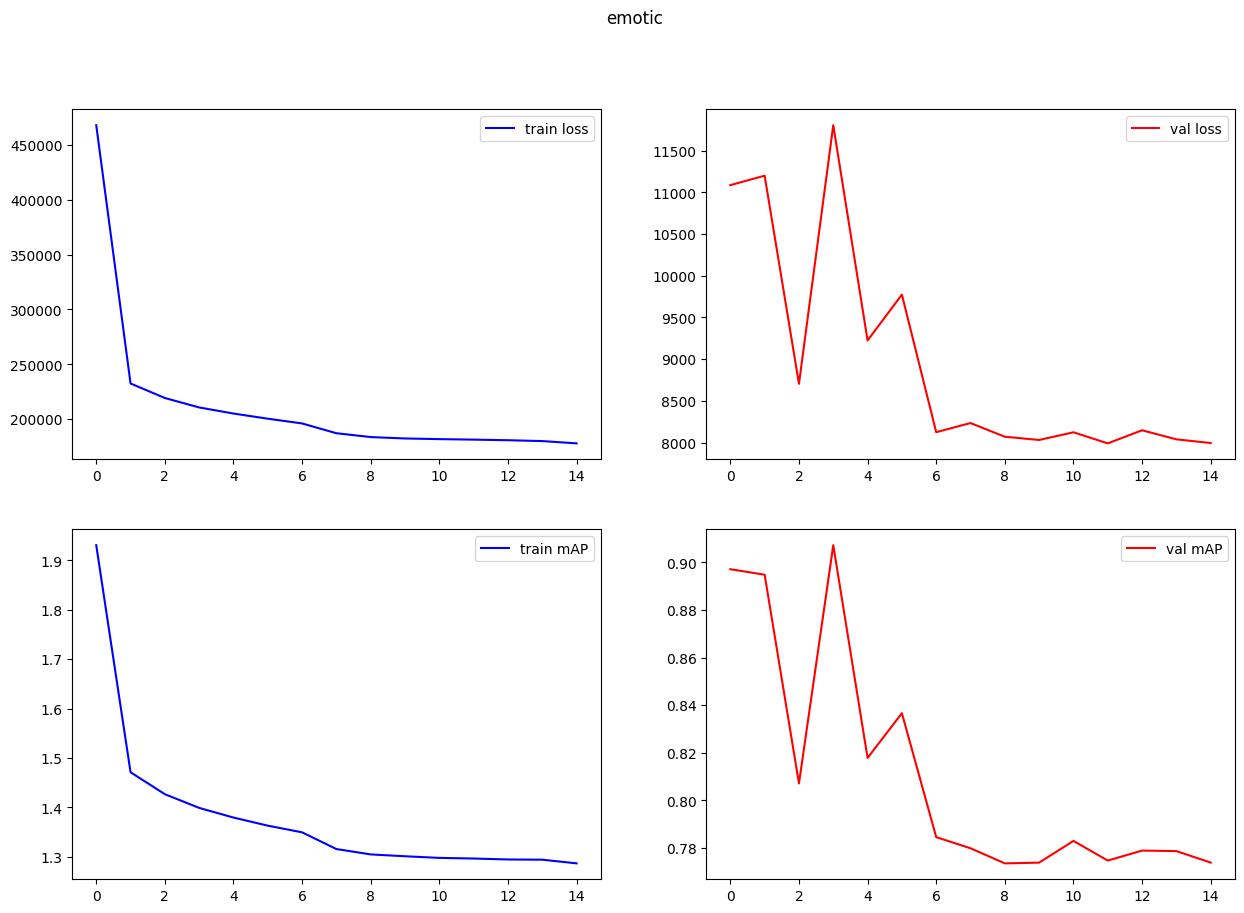

In [ ]:
train_emotic(15, './models', opt, scheduler, [model_context, model_body, model_face, emotic_model], disc_loss=disc_loss, cont_loss=cont_loss_L2, cat_loss_param=1.0, cont_loss_param=1.0)

In [ ]:
model_path = './models'
model_context = torch.load(os.path.join(model_path, 'model_context.pth'))
model_body = torch.load(os.path.join(model_path, 'model_body.pth'))
model_face = torch.load(os.path.join(model_path, 'model_face.pth'))
emotic_model = torch.load(os.path.join(model_path, 'model_emotic.pth'))


model_context.eval()
model_body.eval()
model_face.eval()
emotic_model.eval()

print ('completed cell')

completed cell


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
test_vad = test_data([model_context, model_body, model_face, emotic_model], device, test_loader, test_dataset.__len__())
print ('testing MAE=%.4f' %(test_vad))

starting testing
completed testing
vad [0.8905602  0.97570103 0.9306933 ] (3,) 0.9323182
0.9323182
testing MAE=0.9323



---
# Train 2


## SwinT (Emotic) + Resnet50 (Places365)

In [ ]:
# Get Resnet50 model trained on places dataset.
!mkdir ./places
!wget http://places2.csail.mit.edu/models_places365/resnet50_places365.pth.tar -O ./places/resnet50_places365.pth.tar

mkdir: cannot create directory ‘./places’: File exists
--2023-07-22 07:39:50--  http://places2.csail.mit.edu/models_places365/resnet50_places365.pth.tar
Resolving places2.csail.mit.edu (places2.csail.mit.edu)... 128.52.132.120
Connecting to places2.csail.mit.edu (places2.csail.mit.edu)|128.52.132.120|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 97270159 (93M) [application/x-tar]
Saving to: ‘./places/resnet50_places365.pth.tar’

./places/resnet50_p 100%[===================>]  92.76M  34.8MB/s    in 2.7s    

2023-07-22 07:39:53 (34.8 MB/s) - ‘./places/resnet50_places365.pth.tar’ saved [97270159/97270159]



In [ ]:
# the architecture to use
arch50 = 'resnet50'
model_weight = os.path.join('./places', 'resnet50_places365.pth.tar')

# create the network architecture
model = models.__dict__[arch50](num_classes=365)

#model_weight = '%s_places365.pth.tar' % arch

checkpoint = torch.load(model_weight, map_location=lambda storage, loc: storage) # model trained in GPU could be deployed in CPU machine like this!
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()} # the data parallel layer will add 'module' before each layer name
model.load_state_dict(state_dict)
model.eval()

model.cpu()
torch.save(model.state_dict(), './places/resnet50_state_dict.pth')
print ('completed cell')

completed cell


In [ ]:
model_path_places = './places'

model_context = models.__dict__[arch50](num_classes=365)
context_state_dict = torch.load(os.path.join(model_path_places, 'resnet50_state_dict.pth'))
model_context.load_state_dict(context_state_dict)

model_body = torch.load("/content/drive/MyDrive/VA-prediction/models/SwinT_EMOTIC.pth", map_location=lambda storage, loc: storage)

print (summary(model_context, (3,224,224), device="cpu"))
print (summary(model_body, (3,128,128), device="cpu"))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
class Emotic_PreDataset(Dataset):
  ''' Custom Emotic dataset class. Use preprocessed data stored in npy files. '''
  def __init__(self, x_context, x_body, x_face, y_cat, y_cont, transform, face_transform, context_norm, body_norm, face_norm):
    super(Emotic_PreDataset,self).__init__()
    self.x_context = x_context
    self.x_body = x_body
    self.x_face = x_face
    self.y_cat = y_cat
    self.y_cont = y_cont
    self.transform = transform
    self.face_transform = face_transform
    self.context_norm = transforms.Normalize(context_norm[0], context_norm[1])  # Normalizing the context image with context mean and context std
    self.body_norm = transforms.Normalize(body_norm[0], body_norm[1])           # Normalizing the body image with body mean and body std
    self.face_norm = transforms.Normalize(face_norm[0], face_norm[1])
  def __len__(self):
    return len(self.y_cont)

  def __getitem__(self, index):
    image_context = self.x_context[index]
    image_body = self.x_body[index]
    image_face = self.x_face[index]
    cat_label = self.y_cat[index]
    cont_label = self.y_cont[index]
    # , torch.tensor(cat_label, dtype=torch.float32)
    return self.context_norm(self.transform(image_context)), self.body_norm(self.transform(image_body)), self.face_norm(self.face_transform(image_face)), torch.tensor(cat_label, dtype=torch.float32),  torch.tensor(cont_label, dtype=torch.float32)/10.0

print ('completed cell')

completed cell


In [ ]:
batch_size = 26

context_mean = [0.4690646, 0.4407227, 0.40508908]
context_std = [0.2514227, 0.24312855, 0.24266963]
# print(np.mean(train_body))

body_mean = [0.485, 0.456, 0.406]
body_std = [0.229, 0.224, 0.225]

face_mean = [0.507395516207, 0.507395516207, 0.507395516207]
face_std = [0.255128989415, 0.255128989415, 0.255128989415]

context_norm = [context_mean, context_std]
body_norm = [body_mean, body_std]
face_norm = [face_mean, face_std]

face_train_transform = transforms.Compose([transforms.ToPILImage(),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
                                      transforms.ToTensor()])

face_test_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.ToTensor()])

train_transform = transforms.Compose([transforms.ToPILImage(),
                                      transforms.Resize(size=[232], interpolation=transforms.InterpolationMode.BICUBIC),
                                      transforms.CenterCrop(size=[224]),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
                                      transforms.ToTensor()])


test_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.Resize(size=[232], interpolation=transforms.InterpolationMode.BICUBIC),
                                      transforms.CenterCrop(size=[224]),
                                     transforms.ToTensor()])


train_dataset = Emotic_PreDataset(train_context, train_body, train_face, train_cat, train_cont, \
                                  train_transform, face_train_transform, context_norm, body_norm, face_norm)
val_dataset = Emotic_PreDataset(val_context, val_body, val_face, val_cat, val_cont, \
                                test_transform, face_test_transform, context_norm, body_norm, face_norm)
test_dataset = Emotic_PreDataset(test_context, test_body, test_face, test_cat, test_cont, \
                                 test_transform, face_test_transform, context_norm, body_norm, face_norm)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)


print ('train loader ', len(train_loader), 'val loader ', len(val_loader), 'test', len(test_loader))
print ('completed cell')

train loader  894 val loader  128 test 278
completed cell


# VI. EMOTIC Model + Optimizer

## Face Recognition FER2013

In [ ]:
face_model_path = "/content/drive/MyDrive/VA-prediction/models/FER_trained_model.pt"

In [ ]:
import torch.nn as nn
import torch

class Face_Emotion_CNN(nn.Module):
  def __init__(self):
    super(Face_Emotion_CNN, self).__init__()
    self.cnn1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3)
    self.cnn2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3)
    self.cnn3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
    self.cnn4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
    self.cnn5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
    self.cnn6 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
    self.cnn7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3)
    self.relu = nn.ReLU()
    self.pool1 = nn.MaxPool2d(2, 1)
    self.pool2 = nn.MaxPool2d(2, 2)
    self.cnn1_bn = nn.BatchNorm2d(8)
    self.cnn2_bn = nn.BatchNorm2d(16)
    self.cnn3_bn = nn.BatchNorm2d(32)
    self.cnn4_bn = nn.BatchNorm2d(64)
    self.cnn5_bn = nn.BatchNorm2d(128)
    self.cnn6_bn = nn.BatchNorm2d(256)
    self.cnn7_bn = nn.BatchNorm2d(256)
    self.fc1 = nn.Linear(1024, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 7)
    self.dropout = nn.Dropout(0.3)
    self.log_softmax = nn.LogSoftmax(dim=1)

  def forward(self, x):
    x = self.relu(self.pool1(self.cnn1_bn(self.cnn1(x))))
    x = self.relu(self.pool1(self.cnn2_bn(self.dropout(self.cnn2(x)))))
    x = self.relu(self.pool1(self.cnn3_bn(self.cnn3(x))))
    x = self.relu(self.pool1(self.cnn4_bn(self.dropout(self.cnn4(x)))))
    x = self.relu(self.pool2(self.cnn5_bn(self.cnn5(x))))
    x = self.relu(self.pool2(self.cnn6_bn(self.dropout(self.cnn6(x)))))
    x = self.relu(self.pool2(self.cnn7_bn(self.dropout(self.cnn7(x)))))

    x = x.view(x.size(0), -1)

    x = self.relu(self.dropout(self.fc1(x)))
    x = self.relu(self.dropout(self.fc2(x)))
    x = self.log_softmax(self.fc3(x))
    return x

  def count_parameters(self):
    return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [ ]:
def load_trained_model(model_path):
    model = Face_Emotion_CNN()
    model.load_state_dict(torch.load(model_path, map_location=lambda storage, loc: storage), strict=False)
    return model

In [ ]:
model_face = load_trained_model(face_model_path)

In [ ]:
print(summary(model_face, (1, 48,48), device="cpu"))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 46, 46]              80
       BatchNorm2d-2            [-1, 8, 46, 46]              16
         MaxPool2d-3            [-1, 8, 45, 45]               0
              ReLU-4            [-1, 8, 45, 45]               0
            Conv2d-5           [-1, 16, 43, 43]           1,168
           Dropout-6           [-1, 16, 43, 43]               0
       BatchNorm2d-7           [-1, 16, 43, 43]              32
         MaxPool2d-8           [-1, 16, 42, 42]               0
              ReLU-9           [-1, 16, 42, 42]               0
           Conv2d-10           [-1, 32, 40, 40]           4,640
      BatchNorm2d-11           [-1, 32, 40, 40]              64
        MaxPool2d-12           [-1, 32, 39, 39]               0
             ReLU-13           [-1, 32, 39, 39]               0
           Conv2d-14           [-1, 64,

In [ ]:
class Face_Emotion_CNN_new(nn.Module):
  def __init__(self):
    super(Face_Emotion_CNN_new, self).__init__()
    self.cnn1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3)
    self.cnn2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3)
    self.cnn3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
    self.cnn4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
    self.cnn5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
    self.cnn6 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
    self.cnn7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3)
    self.relu = nn.ReLU()
    self.pool1 = nn.MaxPool2d(2, 1)
    self.pool2 = nn.MaxPool2d(2, 2)
    self.cnn1_bn = nn.BatchNorm2d(8)
    self.cnn2_bn = nn.BatchNorm2d(16)
    self.cnn3_bn = nn.BatchNorm2d(32)
    self.cnn4_bn = nn.BatchNorm2d(64)
    self.cnn5_bn = nn.BatchNorm2d(128)
    self.cnn6_bn = nn.BatchNorm2d(256)
    self.cnn7_bn = nn.BatchNorm2d(256)
    self.fc1 = nn.Linear(1024, 512)
    self.fc2 = nn.Linear(512, 256)
    self.dropout = nn.Dropout(0.3)

  def forward(self, x):
    x = self.relu(self.pool1(self.cnn1_bn(self.cnn1(x))))
    x = self.relu(self.pool1(self.cnn2_bn(self.dropout(self.cnn2(x)))))
    x = self.relu(self.pool1(self.cnn3_bn(self.cnn3(x))))
    x = self.relu(self.pool1(self.cnn4_bn(self.dropout(self.cnn4(x)))))
    x = self.relu(self.pool2(self.cnn5_bn(self.cnn5(x))))
    x = self.relu(self.pool2(self.cnn6_bn(self.dropout(self.cnn6(x)))))
    x = self.relu(self.pool2(self.cnn7_bn(self.dropout(self.cnn7(x)))))

    x = x.view(x.size(0), -1)

    x = self.relu(self.dropout(self.fc1(x)))
    x = self.fc2(x)
    return x

  def count_parameters(self):
    return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [ ]:
state_dict = model_face.state_dict()
del state_dict['fc3.weight']
del state_dict['fc3.bias']

In [ ]:
model_face_new = Face_Emotion_CNN_new()

In [ ]:
model_face_new.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
print(summary(model_face_new, (1, 48,48), device="cpu"))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 46, 46]              80
       BatchNorm2d-2            [-1, 8, 46, 46]              16
         MaxPool2d-3            [-1, 8, 45, 45]               0
              ReLU-4            [-1, 8, 45, 45]               0
            Conv2d-5           [-1, 16, 43, 43]           1,168
           Dropout-6           [-1, 16, 43, 43]               0
       BatchNorm2d-7           [-1, 16, 43, 43]              32
         MaxPool2d-8           [-1, 16, 42, 42]               0
              ReLU-9           [-1, 16, 42, 42]               0
           Conv2d-10           [-1, 32, 40, 40]           4,640
      BatchNorm2d-11           [-1, 32, 40, 40]              64
        MaxPool2d-12           [-1, 32, 39, 39]               0
             ReLU-13           [-1, 32, 39, 39]               0
           Conv2d-14           [-1, 64,

## EMOTIC Model

In [ ]:
model_face = model_face_new
emotic_model = Emotic(list(model_context.children())[-1].in_features, list(model_body.children())[-1].in_features, 256)
model_context = nn.Sequential(*(list(model_context.children())[:-1]))
model_body = nn.Sequential(*(list(model_body.children())[:-1]))

for param in emotic_model.parameters():
  param.requires_grad = True
for param in model_context.parameters():
  param.requires_grad = False
for param in model_body.parameters():
  param.requires_grad = False
for param in model_face.parameters():
  param.requires_grad = False
print ('completed cell')

completed cell


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
opt = optim.Adam((list(emotic_model.parameters()) + list(model_context.parameters()) + \
                  list(model_body.parameters()) + list(model_face.parameters())), lr=0.001, weight_decay=5e-4)

scheduler = StepLR(opt, step_size=7, gamma=0.1)

disc_loss = DiscreteLoss('dynamic', device)

cont_loss_L2 = ContinuousLoss_L2()

print ('completed cell')

completed cell


# VIII. Training + Testing

In [ ]:
train_emotic(15, './models', opt, scheduler, [model_context, model_body, model_face, emotic_model], disc_loss=disc_loss, cont_loss=cont_loss_L2, cat_loss_param=1.0, cont_loss_param=1.0)

epoch = 0 training loss = 467540.9709
vad [1.6646539 2.091746  2.0532045] (3,) 1.9365349
epoch = 0 training MAE = 1.9365
epoch = 0 validation loss = 11853.5499
vad [0.87743986 0.93899524 0.9579767 ] (3,) 0.9248039
epoch = 0 val MAE= 0.9248
saving model at epoch e = 0
epoch = 1 training loss = 237100.4940
vad [1.1888001 1.6640751 1.5968556] (3,) 1.4832436
epoch = 1 training MAE = 1.4832
epoch = 1 validation loss = 10817.2610
vad [0.81524986 1.0101427  0.8572925 ] (3,) 0.8942283
epoch = 1 val MAE= 0.8942
saving model at epoch e = 1
epoch = 2 training loss = 221446.1119
vad [1.1316553 1.6353419 1.5344452] (3,) 1.4338142
epoch = 2 training MAE = 1.4338
epoch = 2 validation loss = 10551.4098
vad [0.7671717 1.0471882 0.8256909] (3,) 0.880017
epoch = 2 val MAE= 0.8800
saving model at epoch e = 2
epoch = 3 training loss = 211135.1503
vad [1.1034212 1.5957507 1.5023348] (3,) 1.4005022
epoch = 3 training MAE = 1.4005
epoch = 3 validation loss = 9564.7904
vad [0.73147947 0.8342532  0.933294  ] (3

In [ ]:
model_path = './models'
model_context = torch.load(os.path.join(model_path, 'model_context.pth'))
model_body = torch.load(os.path.join(model_path, 'model_body.pth'))
model_face = torch.load(os.path.join(model_path, 'model_face.pth'))
emotic_model = torch.load(os.path.join(model_path, 'model_emotic.pth'))


model_context.eval()
model_body.eval()
model_face.eval()
emotic_model.eval()

print ('completed cell')

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
test_vad = test_data([model_context, model_body, model_face, emotic_model], device, test_loader, test_dataset.__len__())
print ('testing MAE=%.4f' %(test_vad))